In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from bs4 import BeautifulSoup as bs
import requests

import selenium
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By

import time
import math

In [67]:
original_URL = r"https://www.universityadmissions.se/intl/search?period=18&freeText="
#first_1000_URL = "https://www.universityadmissions.se/intl/search?period=18&sortBy=nameAsc&numberOfFetchedPages=20"

page = requests.get(original_URL)
soup = bs(page.content, "html.parser")

print(soup.prettify())

<!DOCTYPE html>
<html class="no-js" lang="en" prefix="og: https://ogp.me/ns#" xml:lang="en">
 <head>
  <title>
   Search for courses and programmes - Universityadmissions.se
  </title>
  <meta charset="utf-8"/>
  <meta content="Universityadmissions.se has the entire catalogue of courses and programmes taught in English in a searchable database. Enter search terms or use the filter to help you find the courses you're looking for." name="description"/>
  <meta content="width=device-width, initial-scale=1.0" name="viewport"/>
  <meta content="#ffffff" name="msapplication-TileColor"/>
  <meta content="#ffffff" name="theme-color"/>
  <meta content="telephone=no" name="format-detection"/>
  <meta content="Search for courses and programmes" property="og:title"/>
  <meta content="Universityadmissions.se has the entire catalogue of courses and programmes taught in English in a searchable database. Enter search terms or use the filter to help you find the courses you're looking for." property="o

### Hur många sidor finns det?

In [68]:
num_search_results = int(soup.find("div", class_="searchresult_summary universal_medium").text.strip().split(" ")[1].replace(",",""))
print(f"Number of search results: {num_search_results}")

# number of pages with 50 results each
import math
num_pages = math.ceil(num_search_results/50)
print(f"Number of pages: {num_pages}")


Number of search results: 4160
Number of pages: 84


## Skrapa hem informationen och spara i en dictionary

In [155]:
course_dict = {}

# Loopa igenom alla sidor om 50 resultat per sida
for page_num in range(num_pages):
    print(f"Working with page {page_num}...")

    # Denna URL är för HT2023
    URL = f"https://www.universityadmissions.se/intl/search?period=18&freeText=&page={page_num+1}"
    page = requests.get(URL)
    soup = bs(page.content, "html.parser")

    # Hitta alla kurser/program
    search_result = soup.find("div", class_="searchresult")
    search_result = search_result.find("div", class_="resultsection")
    search_result_cards = search_result.find_all("div", class_="searchresultcard")

    # Loopa igenom varje kurs/program
    for tmp_course_idx, search_result_card in enumerate(search_result_cards):
        course_idx = 50*page_num + tmp_course_idx

        # Skapa en ny dictionary för varje kurs/program
        course_dict[course_idx] = {
            "course_name": "",
            "course_credits": "",
            "course_uni": "",
            "course_location": "",
            "application_status": "",
            "initial_tuition_fee": "",
            "total_tuition_fee": "",
            "period": "",
            "course_dates": "",
            "level": "",
            "language_of_instruction": "",
            "application_code": "",
            "teaching_form": "",
            "meetings": "",
            "pace_of_study": "",
            "instructional_time": "",
            "location": "",
            "meetings": "",
            "subject_areas": "",
            "link": "",
            "course_starts": "",
        }

        #print(f"Working with course {course_idx}...")

        # Header med kursnamn, hp, uni, location, application status
        resultcard_header = search_result_card.find("div", class_="resultcard_header")
        course_name = resultcard_header.find("h3").text
        course_dict[course_idx]["course_name"] = course_name

        course_info = resultcard_header.find("p").text.replace("\n", " ").split(",")
        course_credits = course_info[0].strip().split(" ")[0]
        course_uni = course_info[1].strip()
        course_location = course_info[2].strip().split(" ")[1].strip()

        course_dict[course_idx]["course_credits"] = course_credits
        course_dict[course_idx]["course_uni"] = course_uni
        course_dict[course_idx]["course_location"] = course_location

        application_status = resultcard_header.find("div", class_="applicable_status universal_medium").find("p")
        course_dict[course_idx]["application_status"] = application_status.text


        # Tuition fees
        tuition_fees = search_result_card.find("div", class_="neutralinfoblock infoblock").find_all("p")
        initial_tuition_fee = tuition_fees[1].text.split(":")[1].strip().strip(" SEK*").replace(",", "")
        total_tuition_fee = tuition_fees[2].text.split(":")[1].strip().strip(" SEK*").replace(",", "")

        course_dict[course_idx]["initial_tuition_fee"] = initial_tuition_fee
        course_dict[course_idx]["total_tuition_fee"] = total_tuition_fee


        # Kursdetaljer
        course_details_block = search_result_card.find("div", class_="course_details block")

        for row in course_details_block.find_all("p"):
            text = row.text.strip("\n")
            variable = text.split(":")[0].strip("\n").lower().replace(" ", "_")
            value = text.split(":")[1].strip("\n").replace("\n", " ")

            course_dict[course_idx][variable] = value


        # Subject areas
        resultcard_expanded = search_result_card.find("div", class_="resultcard_expanded universal_high")
        try:
            subject_areas = resultcard_expanded.find_all("p", class_="block")[1].contents[2].text.strip("\n")
        except Exception as e:
            subject_areas = ""
        course_dict[course_idx]["subject_areas"] = subject_areas


        # Link
        link = search_result_card.find("a", class_="external")["href"]
        course_dict[course_idx]["link"] = link




Working with page 0...
Working with page 1...
Working with page 2...
Working with page 3...
Working with page 4...
Working with page 5...
Working with page 6...
Working with page 7...
Working with page 8...
Working with page 9...
Working with page 10...
Working with page 11...
Working with page 12...
Working with page 13...
Working with page 14...
Working with page 15...
Working with page 16...
Working with page 17...
Working with page 18...
Working with page 19...
Working with page 20...
Working with page 21...
Working with page 22...
Working with page 23...
Working with page 24...
Working with page 25...
Working with page 26...
Working with page 27...
Working with page 28...
Working with page 29...
Working with page 30...
Working with page 31...
Working with page 32...
Working with page 33...
Working with page 34...
Working with page 35...
Working with page 36...
Working with page 37...
Working with page 38...
Working with page 39...
Working with page 40...
Working with page 41...
Wo

## Gör en dataframe av dictionaryn

In [173]:
# Gör en dataframe av kurserna
df = pd.DataFrame.from_dict(course_dict, orient='index')
print(f"Shape of dataframe: {df.shape}")
df.head()

Shape of dataframe: (4160, 20)


,course_name,course_credits,course_uni,course_location,application_status,initial_tuition_fee,total_tuition_fee,period,course_dates,level,language_of_instruction,application_code,teaching_form,meetings,pace_of_study,instructional_time,location,subject_areas,link,course_starts
0,3D Image Reconstruction and Analysis in Medicine,9,KTH Royal Institute of Technology,Huddinge,Open for late application,23250,23250,Autumn 2023 Period 1,28 Aug - 21 Jan,Master's,English,KTH-10154,"Course, On-campus",,33%,Daytime,Huddinge,Medical Technologies,https://www.kth.se/student/kurser/kurs/HL2027?...,
1,A History of Mathematics for Teachers,7.5,Dalarna University,Falun,Open for late application,16875,16875,Autumn 2023 Period 1,28 Aug - 5 Nov,Bachelor's,English,HDA-H3EV4,"Course, On-campus",,Half-time,Daytime,Falun,Mathematics,http://www.du.se/redirect/course.aspx?language...,
2,A History of Mathematics for Teachers,7.5,Dalarna University,Falun,Open for late application,16875,16875,Autumn 2023 Period 1,28 Aug - 5 Nov,Bachelor's,English,HDA-H3EV6,"Course, Distance",4,Half-time,Daytime,Falun,Mathematics,http://www.du.se/redirect/course.aspx?language...,
3,A New Heaven and a New Earth,7.5,Newmaninstitutet,Uppsala,Closed for late application,Information not available,12500,Autumn 2023 Period 1,28 Aug - 5 Nov,Bachelor's,English,NMI-L0362,"Course, On-campus",,Half-time,Daytime,Uppsala,Humanities,https://newman.se/kurser-ht-2023/#a-new-heaven...,
4,A Theme from the History of Theoretical Philos...,7.5,Stockholm University,Stockholm,Open for late application,11250,11250,Autumn 2023 Period 1,28 Aug - 29 Oct,Bachelor's,English,SU-10924,"Course, On-campus",,Half-time,Daytime,Stockholm,Philosophy and Logic,https://sisu.it.su.se/search/info/FITE10/en?ev...,


### Info och statistik om dataframen

In [157]:
df.describe()

,course_name,course_credits,course_uni,course_location,application_status,initial_tuition_fee,total_tuition_fee,period,course_dates,level,language_of_instruction,application_code,teaching_form,meetings,pace_of_study,instructional_time,location,subject_areas,link,course_starts
count,4160,4160,4160,4160,4160,4160,4160,4160,4160,4160,4160,4160,4160,4160,4160,4160,4160,4160,4160,4160
unique,3425,27,37,51,7,323,409,2,81,4,11,4141,6,32,12,6,52,950,3808,10
top,Master's Programme in Language Science,7.5,Stockholm University,Stockholm,Open for late application,11250,11250,Autumn 2023 Period 1,,Master's,English,,"Course, On-campus",,Full-time,Daytime,Stockholm,Biology,http://smi.se/english/index.html,
freq,24,1659,690,828,2105,177,177,3183,1518,2843,3919,20,2051,3411,2452,3630,837,139,17,2715


In [114]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4160 entries, 0 to 4159
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   course_name              4160 non-null   object 
 1   course_credits           4160 non-null   float32
 2   course_uni               4160 non-null   object 
 3   course_location          4160 non-null   object 
 4   application_status       4160 non-null   object 
 5   initial_tuition_fee      4160 non-null   object 
 6   total_tuition_fee        4160 non-null   object 
 7   period                   4160 non-null   object 
 8   course_dates             4160 non-null   object 
 9   level                    4160 non-null   object 
 10  language_of_instruction  4160 non-null   object 
 11  application_code         4160 non-null   object 
 12  teaching_form            4160 non-null   object 
 13  meetings                 4160 non-null   object 
 14  pace_of_study            4160

### Manipulera dataframe

In [229]:
# Gör om course_credits (HP) till float32
df.course_credits = df.course_credits.astype("float32")

# Spara till csv
#df.to_csv("antagningsstatistik.csv", index=False)

In [175]:
df.describe()

,course_credits
count,4160.000000
mean,45.387859
std,52.494816
min,0.000000
25%,7.500000
50%,15.000000
75%,120.000000
max,300.000000


### Omvandla tuition fee till tal?

In [221]:
df.initial_tuition_fee.unique()

array(['23250', '16875', 'Information not available', '11250', '21000',
       '8745', '11125', '11660', '21750', '46500', '45000', '19300',
       '48000', '17500', '38060', '88050', '18550', '100000', '37500',
       '18800', '15500', '31000', '35700', '14400', '12600', '21375',
       '19375', '74982', '17850', '11598', '11498', '35000', '20667',
       '18000', '18625', '71400', '23333', '12900', '127500', '17873',
       '63000', 'None', '22250', '1450', '11600', '13050', '17400',
       '40000', '15625', '15000', '56500', '13090', '62500', '67000',
       '75000', '7200', '10333', '19030', '57500', '12313', '38054',
       '12000', '67500', '10000', '74500', '60000', '10998', '77500',
       '80000', '13875', '12083', '18750', '26163', '36000', '13750',
       '32500', '105000', '23400', '93600', '70000', '72250', '18125',
       '150000', '62000', '9900', '5625', '9800', '51000', '50000',
       '130000', '145000', '119000', '95000', '20000', '90000', '43500',
       '120000', '

In [216]:
# Icke-numerisk data kan vara antingen "Information not available" eller "None"
rows_to_drop = df.loc[df.initial_tuition_fee.isin(["None", "Information not available"]) | df.total_tuition_fee.isin(["None", "Information not available"])].index
tuition_fees = df.drop(rows_to_drop)[["initial_tuition_fee", "total_tuition_fee"]]

# Konvertera till numerisk data
tuition_fees = tuition_fees.apply(pd.to_numeric, errors='coerce')

print(f"Shape of tuition_fees: {tuition_fees.shape}")
tuition_fees.head()

Shape of tuition_fees: (4083, 2)


,initial_tuition_fee,total_tuition_fee
0,23250,23250
1,16875,16875
2,16875,16875
4,11250,11250
5,21000,21000


In [217]:
tuition_fees.describe()

,initial_tuition_fee,total_tuition_fee
count,4083.000000,4.083000e+03
mean,39058.652217,1.059475e+05
std,32559.397913,1.440587e+05
min,1450.000000,1.450000e+03
25%,15000.000000,1.500000e+04
50%,23250.000000,2.340000e+04
75%,60000.000000,1.820000e+05
max,276500.000000,1.657550e+06


In [222]:
df.columns

Index(['course_name', 'course_credits', 'course_uni', 'course_location',
       'application_status', 'initial_tuition_fee', 'total_tuition_fee',
       'period', 'course_dates', 'level', 'language_of_instruction',
       'application_code', 'teaching_form', 'meetings', 'pace_of_study',
       'instructional_time', 'location', 'subject_areas', 'link',
       'course_starts'],
      dtype='object')

### Lite snabb statistik

In [225]:
df.language_of_instruction.value_counts()

language_of_instruction
English       3919
Swedish         95
French          41
Spanish         27
German          23
Portuguese      18
Chinese         14
Japanese        12
Italian          8
Russian          2
Arabic           1
Name: count, dtype: int64

In [227]:
df.period.value_counts()

period
Autumn 2023 Period 1    3183
Autumn 2023 Period 2     977
Name: count, dtype: int64

In [228]:
df.teaching_form.value_counts()

teaching_form
Course, On-campus               2051
Programme, On-campus            1227
Course, Distance                 791
Programme, Distance               78
Course, Distance learning          9
Programme, Distance learning       4
Name: count, dtype: int64

## Visualiseringar

In [127]:
# Ändra tema på Seaborn
sns.set_theme(style="darkgrid")

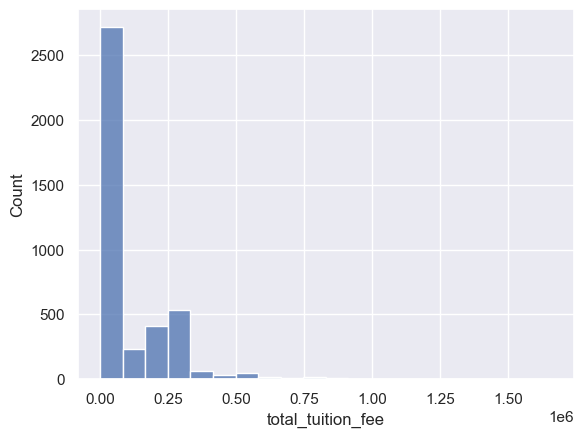

In [220]:
sns.histplot(data=tuition_fees, x='total_tuition_fee', bins=20)
plt.show()

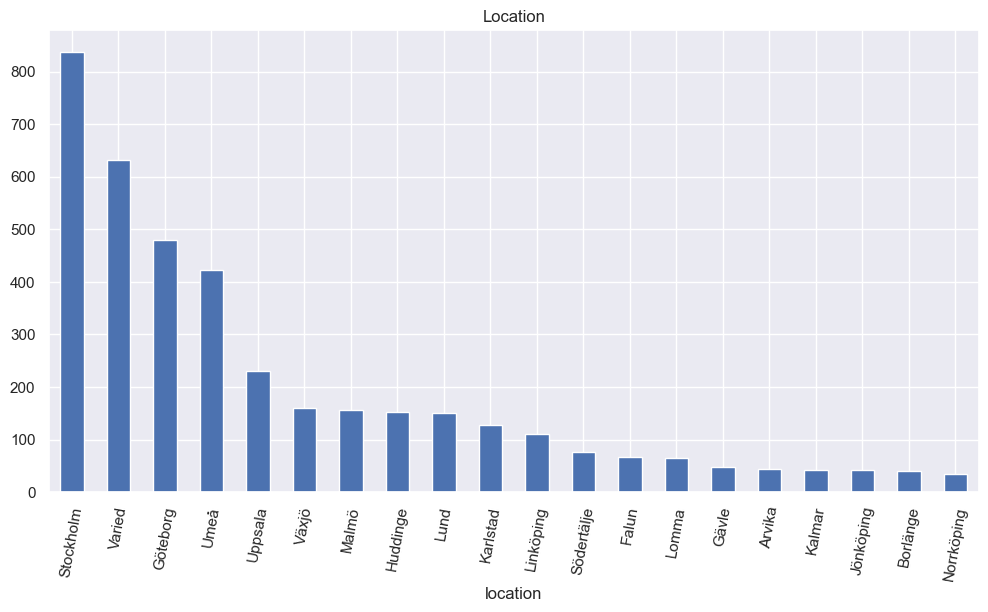

In [139]:
df.location.value_counts().nlargest(20).plot(kind='bar', figsize=(12, 6), title='Location')
plt.title("Topp X områden")
plt.xticks(rotation=80)
plt.show()

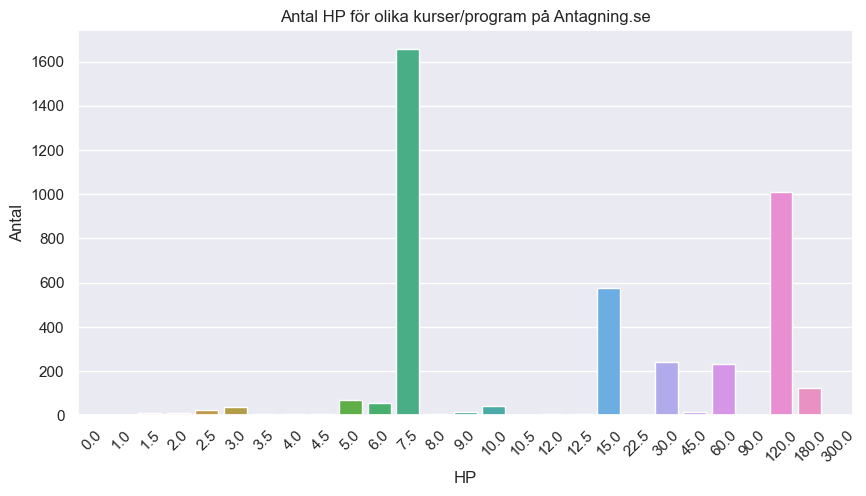

In [128]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.countplot(data=df, x="course_credits")
plt.title("Antal HP för olika kurser/program på Antagning.se")
plt.xlabel("HP")
plt.ylabel("Antal")
plt.xticks(rotation=45)
plt.show()

## Random shizz

In [19]:
search_result_card = search_result_cards[2]#[98]

course_details_block = search_result_card.find("div", class_="course_details block")
values = []
meetings = "Not specified"
for row in course_details_block.find_all("p"):
    text = row.text.strip("\n")
    variable = text.split(":")[0].strip("\n").lower().replace(" ", "_")
    value = text.split(":")[1].strip("\n").replace("\n", " ")
    values.append(value)

    print(variable + " --> " + value)


values

period --> Autumn 2023 Period 1
course_dates --> 28 Aug - 5 Nov
level --> Bachelor's
language_of_instruction --> English
application_code --> HDA-H3EV6
teaching_form --> Course, Distance
meetings --> 4
pace_of_study --> Half-time
instructional_time --> Daytime
location --> Falun


['Autumn 2023 Period 1',
 '28 Aug - 5 Nov',
 "Bachelor's",
 'English',
 'HDA-H3EV6',
 'Course, Distance',
 '4',
 'Half-time',
 'Daytime',
 'Falun']

In [20]:
course_dict = {}

for course_idx, search_result_card in enumerate(search_result_cards[:10]):
    course_dict[course_idx] = {
        "period":"",
        "course_dates":"",
        "level":"",
        "language_of_instruction":"",
        "application_code":"",
        "teaching_form":"",
        "meetings":"",
        "pace_of_study":"",
        "instructional_time":"",
        "location":""
    }

    course_details_block = search_result_card.find("div", class_="course_details block")
    values = []

    for row in course_details_block.find_all("p"):
        text = row.text.strip("\n")
        variable = text.split(":")[0].strip("\n").lower().replace(" ", "_")
        value = text.split(":")[1].strip("\n").replace("\n", " ")
        values.append(value)

        course_dict[course_idx][variable] = value

course_dict

{0: {'period': 'Autumn 2023 Period 1',
  'course_dates': '28 Aug - 21 Jan',
  'level': "Master's",
  'language_of_instruction': 'English',
  'application_code': 'KTH-10154',
  'teaching_form': 'Course, On-campus',
  'meetings': '',
  'pace_of_study': '33%',
  'instructional_time': 'Daytime',
  'location': 'Huddinge'},
 1: {'period': 'Autumn 2023 Period 1',
  'course_dates': '28 Aug - 5 Nov',
  'level': "Bachelor's",
  'language_of_instruction': 'English',
  'application_code': 'HDA-H3EV4',
  'teaching_form': 'Course, On-campus',
  'meetings': '',
  'pace_of_study': 'Half-time',
  'instructional_time': 'Daytime',
  'location': 'Falun'},
 2: {'period': 'Autumn 2023 Period 1',
  'course_dates': '28 Aug - 5 Nov',
  'level': "Bachelor's",
  'language_of_instruction': 'English',
  'application_code': 'HDA-H3EV6',
  'teaching_form': 'Course, Distance',
  'meetings': '4',
  'pace_of_study': 'Half-time',
  'instructional_time': 'Daytime',
  'location': 'Falun'},
 3: {'period': 'Autumn 2023 Peri

In [55]:
# scrape site with selenium

url = first_1000_URL
driver = webdriver.Safari()
driver.maximize_window()
driver.get(url)

# click on show more button
for x in range(63):
    for y in range(3):
        try:
            show_more_button = driver.find_element(By.XPATH, '//*[@id="showmorehits"]/button')
            #time.sleep(2)
            show_more_button.click()
            time.sleep(5)
        except Exception:
            time.sleep(3)

search_result = driver.find_element(By.XPATH, '/html/body/main/section/div[3]')
soup = bs(search_result.get_attribute("outerHTML"), "html.parser")
print(len(soup.find_all("div", class_="searchresultcard")))

driver.close()

KeyboardInterrupt: 